In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler

from keras.utils import np_utils

import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

Using TensorFlow backend.


In [2]:
def missing(df):
    print('Size of testing dataset : %d' % (df.shape[0]))
    df1 = df.dropna()
    print('Size of testing dataset DropNA : %d' % (df1.shape[0]))

def onehot(df):
    m1, m1.dim = onehot2(df.manufacturer)  
    s1, s1.dim = onehot2(df.salesIndex)  
    
    df1 = pd.concat([df, m1, s1], axis=1, join_axes=[df_items1.index])  
    df2 = df1.drop(["manufacturer", "salesIndex"], axis=1)
    print(df2.shape)
    return df2

def onehot2(df):
    df_oh = pd.DataFrame(np_utils.to_categorical(df,(max(df)+1)))
    original_dim = df_oh.shape[1]
    print('original dimension : %d' % df_oh.shape[1])
    return df_oh, original_dim

## training dataset

In [3]:
def pre_train(df):
    df["number"] = df["revenue"] / df["price"]
    df["dif"] = df["price"] - df["competitorPrice"]
    
    ################################################# given label
    click = df[(df.click == 1)]
    basket = df[(df.basket == 1)]
    order = df[(df.order == 1)]
    click["class_label"] = 0
    basket["class_label"] = 0
    order["class_label"] = 1
    df1 = pd.concat([click, basket, order])
    
    ################################################# feature onehot
    ad, ad_dim = onehot2(df1.adFlag)
    av, av_dim = onehot2(df1.availability)
    df2 = pd.concat([df1, pd.DataFrame(ad), pd.DataFrame(av)], axis=1, join_axes=[df1.index])
    df3 = df2.drop(["adFlag", "availability"], axis=1)
    return df3

In [5]:
df_train0 = pd.read_csv("DATA/DMC_2017_task/train.csv", sep = "|")
print(df_train0.shape)

df_train = pre_train(df_train0)
df_train.head()
print(df_train.shape)

(2756003, 11)


/Users/Shawn/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shawn/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shawn/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

original dimension : 2
original dimension : 5
(2756003, 19)


In [6]:
pid_fre = pd.DataFrame(df_train['pid'].value_counts())
pid_fre.columns = ["fre"]
print(pid_fre.shape)
pid_s = pid_fre[pid_fre.fre < 10]
pid_l = pid_fre[pid_fre.fre > 15000]

pid_ss = np.array(pid_s.index - 1)
pid_ll = np.array(pid_l.index - 1)
print('size of pid_ss : %d' % pid_ss.shape[0])
print('size of pid_l : %d' % pid_ll.shape[0])
print('size of pid_0 : %d' % (22035 - pid_fre.shape[0]))

(21928, 1)
size of pid_ss : 4409
size of pid_l : 1
size of pid_0 : 107


In [7]:
pid_l.head()

,fre
2655,53785


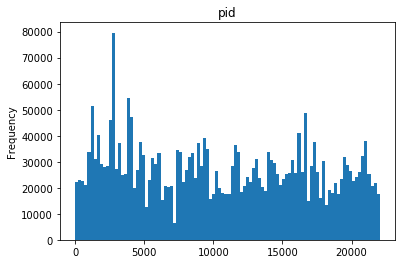

In [6]:
df_train.pid.plot.hist(title = 'pid', bins = 100)
plt.show()

## item

In [7]:
df_items00 = pd.read_csv("DATA/DMC_2017_task/items.csv", sep = "|")
print(df_items00.shape)

del df_items00["campaignIndex"]
df_items00.pharmForm = df_items00.pharmForm.str.upper()
display(df_items00.isnull().sum())

(22035, 11)


pid                  0
manufacturer         0
group                0
content              0
unit                 0
pharmForm         2327
genericProduct       0
salesIndex           0
category          4627
rrp                  0
dtype: int64

### 刪掉交易次數很少的

In [8]:
pid_0 = np.array(list(set(list(df_items00.index)) - set(list(pid_fre.index - 1))))

df_items0 = df_items00.drop(df_items00.index[pid_0])
df_items0 = df_items0.drop(df_items00.index[pid_ss])
df_items0 = df_items0.drop(df_items0.index[pid_ll])
df_items0 = df_items0.reset_index(drop=True, inplace=False, col_level=0, col_fill='')

## 前處理 和 onehotencode

In [9]:
content = pd.DataFrame(df_items0.content.str.split('X',2).tolist(), columns = ['x','y','z'])
content = content.fillna('1')
content.x = pd.to_numeric(content.x, errors='coerce')
content.y = pd.to_numeric(content.y, errors='coerce')
content.z = pd.to_numeric(content.z, errors='coerce')
content['Content'] = content.x * content.y * content.z
df_items1 = pd.concat([df_items0, content], axis=1, join_axes=[df_items0.index])
del df_items1["x"]
del df_items1["y"]
del df_items1["z"]
del df_items1["content"]

df_items1.head()

,pid,manufacturer,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content
0,3,1,2FOI,G,GLO,0,40,NaN,16.45,10.0
1,4,1,2FOI,ST,TAB,0,40,NaN,10.89,80.0
2,5,2,10OJ03JS,ST,PUL,0,40,1.0,22.53,8.0
3,7,3,21OKG,ST,TRA,0,53,3.0,21.45,15.0
4,8,1,2FOI,ST,TAB,0,40,2.0,10.89,80.0


In [130]:
df_items1.describe()

,pid,manufacturer,genericProduct,salesIndex,category,rrp,Content,cluster
count,17518.000000,17518.000000,17518.000000,17518.000000,15147.000000,17518.000000,17516.000000,17518.000000
mean,11069.655668,218.739696,0.037162,48.626213,112.914042,17.744712,120.368892,0.910720
std,6408.075484,219.109487,0.189163,6.077615,93.467944,18.709280,385.983920,0.807298
min,3.000000,1.000000,0.000000,40.000000,1.000000,0.070000,0.250000,0.000000
25%,5454.250000,61.000000,0.000000,40.000000,35.000000,7.250000,18.000000,0.000000
50%,11150.500000,152.000000,0.000000,53.000000,90.000000,12.115000,50.000000,1.000000
75%,16633.750000,308.000000,0.000000,53.000000,164.000000,21.660000,100.000000,2.000000
max,22035.000000,1067.000000,1.000000,53.000000,409.000000,284.650000,22000.000000,2.000000


In [10]:
df_items2 = onehot(df_items1)
df_items3 = pd.get_dummies(df_items2)
print(df_items3.shape)

original dimension : 1068
original dimension : 54
(17518, 1130)
(17518, 1829)


## missing value 補平均

In [11]:
df_items3.category = df_items3.category.fillna(value = df_items3.category.mean())
df_items3.Content = df_items3.Content.fillna(value = df_items3.Content.mean())

In [12]:
column_conti = ["category","rrp","Content"]
df_num = df_items3[column_conti]
sc = MinMaxScaler(feature_range=(0, 1), copy=True)
Z = pd.DataFrame(sc.fit_transform(df_num))
Z.columns = column_conti
################################################ reset row index
df_cat = df_items3.drop(column_conti, axis=1)
df_cat = df_cat.reset_index(drop=True, inplace=False, col_level=0, col_fill='')

df_st = df_cat.join(Z, on=None, how='inner', lsuffix='', rsuffix='', sort=False)

In [13]:
X = df_st.iloc[:, 1:]
print(X.shape)

(17518, 1828)


In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2,
          copy = True,
          whiten = False,
          svd_solver = 'auto',
          tol = 0.0,
          iterated_power = 'auto',
          random_state = 100)

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2,
            perplexity = 30.0,
            early_exaggeration = 4.0,
            learning_rate = 1000.0,
            n_iter = 1000,
            n_iter_without_progress = 30,
            min_grad_norm = 1e-07,
            metric = 'euclidean',
            init = 'random',
            verbose = 0,
            random_state = 100,
            method = 'barnes_hut',
            angle = 0.5)

In [36]:
def kmeans(n_clusters):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters = n_clusters,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 300,
                    tol = 0.0001,
                    precompute_distances = 'auto',
                    verbose = 0,
                    random_state = 100,
                    copy_x = True,
                    n_jobs = 1,
                    algorithm = 'auto')
    kmeans.fit(X)
    label = pd.DataFrame(kmeans.labels_)
    
    X_pca = pd.DataFrame(pca.fit_transform(X))
    X1 = pd.concat([X_pca, label], axis=1, join_axes=[X_pca.index])
    X1.columns = ["a","b","l"]
    cmap = cm.get_cmap('Spectral')
    X1.plot.scatter(x = "a", y = "b", s = 10, c = "l", cmap = cmap)
    plt.show()
    print(X1["l"].value_counts())
    return label

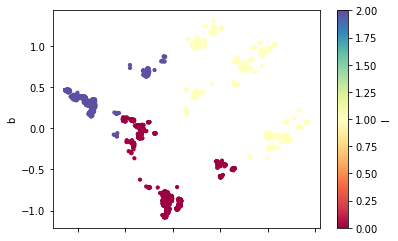

0    6560
1    5962
2    4996
Name: l, dtype: int64


In [37]:
label = kmeans(3)

In [38]:
df_items1["cluster"] = label
df_items1.head()

,pid,manufacturer,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content,cluster
0,3,1,2FOI,G,GLO,0,40,NaN,16.45,10.0,1
1,4,1,2FOI,ST,TAB,0,40,NaN,10.89,80.0,1
2,5,2,10OJ03JS,ST,PUL,0,40,1.0,22.53,8.0,1
3,7,3,21OKG,ST,TRA,0,53,3.0,21.45,15.0,0
4,8,1,2FOI,ST,TAB,0,40,2.0,10.89,80.0,1


from sklearn.cluster import DBSCAN  
db = DBSCAN(eps = 5,  
            min_samples = 1000,  
            metric = 'euclidean',  
            algorithm = 'auto',  
            leaf_size = 30,  
            p = None,  
            n_jobs = 1)  

db.fit(X)  
label_db = pd.DataFrame(db.labels_)  

## combine training and items

In [132]:
result0 = pd.merge(df_train, df_items1, how='inner', on=['pid']) #df_items
result0 = result0.sort_values(['lineID'], ascending=True)

##################################################### hold on last month
hold_result = result0[result0.day > 65]
hold_result = hold_result.dropna()
hold_result = hold_result.reset_index(drop = True)

result = result0[result0.day < 66]
result = result.dropna()
result = result.reset_index(drop = True)

print('Number of hold_result: %d' % hold_result.shape[0])
print('Number of result training: %d' % result.shape[0])
result.iloc[:5, :20]

Number of hold_result: 782103
Number of result training: 1622522


,lineID,day,pid,competitorPrice,click,basket,order,price,revenue,number,dif,class_label,0,1,0,1,2,3,4,manufacturer
0,1,1,6570,14.60,1,0,0,16.89,0.00,0.0,2.29,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,255
1,2,1,14922,8.57,0,1,0,8.75,0.00,0.0,0.18,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,18
2,3,1,16382,14.77,0,1,0,16.06,0.00,0.0,1.29,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,41
3,4,1,1145,6.59,0,0,1,6.55,6.55,1.0,-0.04,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,52
4,5,1,3394,4.39,0,0,1,4.14,4.14,1.0,-0.25,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,90


In [120]:
def pre_all(df):
    df1 = df.drop(["lineID", "number", "click", "basket", "order", "cluster", "revenue"], axis=1)
    # class_label,revenue
    
    df_num = df1[column_conti]
    sc = MinMaxScaler(feature_range=(0, 1), copy=True)
    Z = pd.DataFrame(sc.fit_transform(df_num))
    Z.columns = column_conti
    
    df_cat = df1.drop(column_conti, axis=1)
    df_cat = df_cat.reset_index(drop=True, inplace=False, col_level=0, col_fill='')
    
    df_st = df_cat.join(Z, on=None, how='inner', lsuffix='', rsuffix='', sort=False)
    df_st1 = pd.get_dummies(df_st)
    return df_st1

In [121]:
################################################ 資料分群做回歸。
df0 = result[(result.cluster == 1)]
###

print(df0['order'].value_counts())

column_conti = ["day", "pid", "competitorPrice", "price", "dif",
                "manufacturer", "salesIndex", "category", "rrp", 'Content']
df_st = pre_all(df0)

0    653063
1    271504
Name: order, dtype: int64


In [122]:
def split(df):
    X = np.array(df.drop(["class_label"], axis=1))
    y = np.array(df[["class_label"]])
    
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    print('Number of training: %d' % X_train.shape[0])
    print('Number of testing: %d' % X_test.shape[0])
    return X_train, X_test, y_train, y_test

def cross_val(model, cv):
    from sklearn.cross_validation import cross_val_score
    scores_dt0 = cross_val_score(model, X_train, y_train, cv = cv, n_jobs = 4)  
    scores_dt = np.sum(scores_dt0) / cv
    
    print("===cross_val===")  
    print(scores_dt)  

In [123]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 100, 
                            max_features = 'log2', 
                            criterion = 'mse', 
                            max_depth = None, 
                            min_samples_split = 20, 
                            min_samples_leaf = 10, 
                            min_weight_fraction_leaf = 0.0, 
                            max_leaf_nodes = None, 
                            min_impurity_split = 1e-07, 
                            bootstrap = True, 
                            oob_score = True, 
                            n_jobs = 1, 
                            random_state = 0, 
                            verbose = 0, 
                            warm_start = False)

In [124]:
X_train, X_test, y_train, y_test = split(df_st)

Number of training: 739653
Number of testing: 184914


In [125]:
#cross_val(rfr, 10)

rfr.fit(X_train, y_train)  
pred = rfr.predict(X_test).reshape(y_test.shape[0], 1)  
print(rfr.oob_score_)  

score = np.dot((pred - y_test).T, (pred - y_test))  
print("===Euclidean Distance===")  
print(score[0, 0])  

a = pd.DataFrame(np.concatenate((np.array(y_test), pred), axis=1))  
a.columns = ["test", "pred"]  

a.plot.scatter(x = 'test', y = 'pred', s = 10, alpha = 0.2)  
plt.show()  

0.112749478825, 9904614.19936

In [126]:
label_number = np.array(df0['order'].value_counts())
weight = float(label_number[0] / label_number[1])

In [127]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=3, 
                              random_state=0
                              ,class_weight = {1: weight, 0: 1.0})

In [128]:
def processing(model):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix

    model.fit(X_train, y_train)
    print("training down")
    y_pred = model.predict(X_test).reshape(y_test.shape[0], 1)
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    print('Accuracy : %.2f' % ((y_test == y_pred).sum() / y_test.shape[0]))
    print('Accuracy (sklearn): %.2f' % accuracy_score(y_test, y_pred))
    print("==confusion matrix==")
    print(confusion_matrix(y_test, y_pred, labels=[0,1], sample_weight=None))

In [129]:
processing(tree)

training down
Misclassified samples: 61606
Accuracy : 0.00
Accuracy (sklearn): 0.67
==confusion matrix==
[[100131  30457]
 [ 31149  23177]]


> 0.69 2,  
0.67 1,  
0.63 0